In [1]:
#!pip install torchvision==0.8.0

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary


# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Thu Apr  1 07:09:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load the MNIST Dataset

In [4]:
'''
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
'''

"\nfrom six.moves import urllib\nopener = urllib.request.build_opener()\nopener.addheaders = [('User-agent', 'Mozilla/5.0')]\nurllib.request.install_opener(opener)\n"

In [5]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
'''
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)
'''

"\ntransforms_mnist = transforms.Compose([\n                                       transforms.ToTensor(),\n                                       transforms.Normalize((0.1307,), (0.3081,))\n                                       ])\n\nmnist_data_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=transforms_mnist)\nmnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)\n"

In [6]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST

transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = MNIST(root = '../data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = MNIST(root = '../data/mnist/', train=False, download=True, transform=transforms_mnist)

--2021-04-01 07:09:35--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-01 07:09:35--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
MNIST.tar.gz: Operation not supported

Cannot write to ‘MNIST.tar.gz’ (Success).
tar (child): MNIST.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [7]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [8]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [9]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [10]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


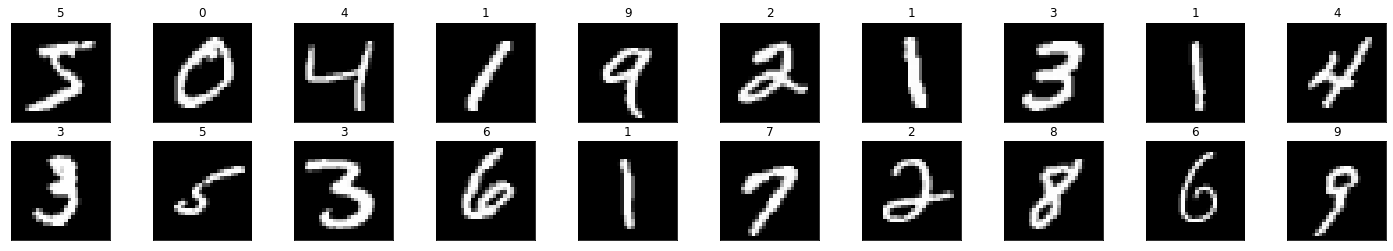

In [11]:
visualize(mnist_data_train)

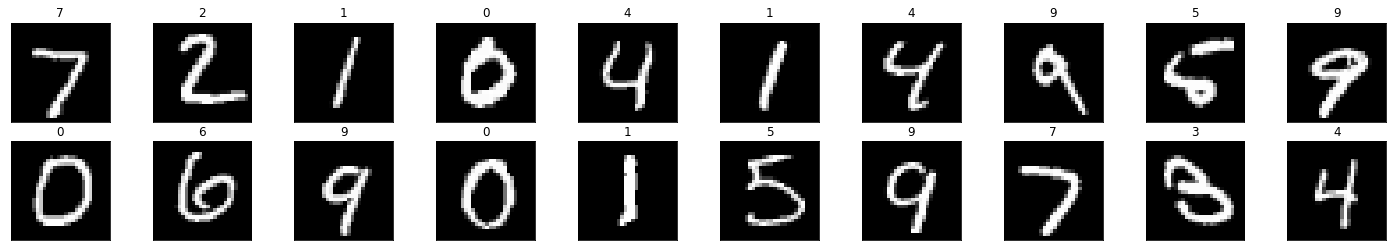

In [12]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [13]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]
  #data_labels = dataset.targets.numpy()
  #print(data_labels)

  for i in range(clients):
    x = np.random.choice(image_idxs, num_items_per_client, replace=False)
    client_dict[i] = set(x)
    image_idxs = list(set(image_idxs) - client_dict[i])
  '''
  #print(len(client_dict))
  #random.randrange()
  n = []
  cli = list(range(clients))
  for i in range(int(M*clients)):
    new = np.random.choice(cli)
    n.append(new)
    cli.remove(new)
  #n = np.random.choice(range(clients), int(0.1*clients), replace=False)
  #n = list(n)
  print(n)
  for i in n:
    j = 0
    while j < int(W*num_items_per_client):
      l = list(client_dict[i])
      newl = dataset.targets[int(l[j])].item()
      dataset.targets[int(l[j])] = torch.Tensor([(newl+1)%10])

      j += 1

  print(dataset.targets)
  
  c = 0
  for i in dataset.targets:
    if i == torch.Tensor([1]):
      c += 1
  print(c)
  
  '''
  return client_dict


In [14]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  
  #print(data_labels)
  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]
  #print(idxs)
  #print(len(idxs))

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
    #print(client_dict)
  '''
  n = []
  cli = list(range(clients))
  for i in range(int(0.5*clients)):
    new = np.random.choice(cli)
    n.append(new)
    cli.remove(new)
  #n = np.random.choice(range(clients), int(0.1*clients), replace=False)
  #n = list(n)
  print(n)
  for i in n:
    j = 0
    while j < int(0.8*num_shards_per_client):
      l = list(client_dict[i])
      print(l)
      newl = dataset.targets[int(l[j])].item()
      dataset.targets[int(l[j])] = torch.Tensor([1])  #(newl+1)% 10

      j += 1

  print(dataset.targets)

  
  
  M = 0.1
  for n in range(M*K):
    ran = random.randint(0, K)
    for x in data_dict:
      print(len(data_dict[x]))
      #for i in range(0.5*len(data_dict[x])):

  
  '''
  return client_dict





## Models

In [15]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [16]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

### Print Model Summaries

In [17]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

## Federated Averaging

### Local Training (Client Update)

Local training for the model on client side

In [18]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)

    self.learning_rate = learning_rate
    self.epochs = epochs



  def train(self, model):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

### Server Side Training

Following Algorithm 1 from the paper

In [19]:
def training(model, rounds, batch_size, lr, ds, data_dict, C, K, E, plt_title, plt_color, M):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []
  
  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss = [], []

    m = max(int(C*K), 1)
    newM = int(M*m)

    S_t = np.random.choice(range(K), m, replace=False)
    print(S_t)
    c = 0

    for i in range(len(S_t)):
      if c == newM:
        break
      c += 1
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[S_t[i]])
      weights, loss = local_update.train(model=copy.deepcopy(model))
      
      for k in weights.keys():
        t = torch.Tensor(weights[k].shape).cuda()
        t.fill_(1)
        weights[k] = t      
      
      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))


    for k in range(newM, len(S_t)):

      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, idxs=data_dict[S_t[k]])
      weights, loss = local_update.train(model=copy.deepcopy(model))
      
      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    train_loss.append(loss_avg)

  end = time.time()
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig('/gdrive/My Drive/FedPerf/MNIST/FedAvg/Robustness/M_0.1/n_1/' + plt_title +'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model

## Testing Loop

In [20]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  for i in range(10):
    if total_class[i]>0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))

# MNIST MLP on IID

### Train

[95 31 96 19 57 80 70 59 99 84 18 92 66 90 36 32 27 85 10 87  4 20 89 26
 52 97  0 88 40 53 54 46 44 13 86 47 64 55 39 60 37 74 25 15 81 24  3 42
 73 69]
Round: 1... 	Average Loss: 0.501
[50  8 42 71 89 11 72 74 52 56 31 75 18 39 55 33 16 45 62 54 99 17 19 96
 41 14  5 78 60 92 34 10 12 59 36 32 43 67 80 44 90 88 20 69 30  0 68 28
 85 87]
Round: 2... 	Average Loss: 4.721
[ 7 42 89 96 25 75 17 32 83 88 51 20 45 55 18  6 34  2 64 73 10 92 63 86
 52 44 49 72 93 68 76 70 36 47 15  8  3  1 37 78 95 81 12 56 59 28 79 69
  0 16]
Round: 3... 	Average Loss: 4.52
[18  0 68 56 27 14  5 35 82 10 79 95 86  2 65  9 26 43 96 84 75 13 87 44
 20 74 78 92 33 39 99 70 63  3 57 49 54 24 46 15  8 58  1 76 98 72 90 52
 93 19]
Round: 4... 	Average Loss: 4.684
[69 10 31 88 29 22 46  8 18 26 91 37 64 15 70 58 16  3 86 75 73 62 79  1
 14 39 56 32 42 95 19 74 99 49 66 30 50 23 93 85 97 17  4 94 61 71 48 35
 24 59]
Round: 5... 	Average Loss: 5.204
[31  2 82  6 42 56  7 23 38 83  0 70 11 44 93 54 61 53 95 21 46 76

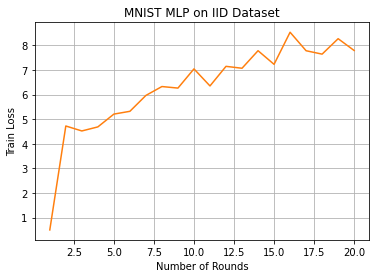

In [21]:
# number of training rounds
rounds = 20
# client fraction
C = 0.5
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.05
# dict containing different type of data partition
data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "MNIST MLP on IID Dataset", "orange", 0.1)


### Test

In [22]:
criterion = nn.CrossEntropyLoss()
testing(mnist_mlp_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 8.424709

Test Accuracy of     0: 43% (33/76)
Test Accuracy of     1: 100% (90/90)
Test Accuracy of     2: 35% (32/91)
Test Accuracy of     3: 10% ( 8/73)
Test Accuracy of     4:  1% ( 1/89)
Test Accuracy of     5:  1% ( 1/68)
Test Accuracy of     6: 24% (15/62)
Test Accuracy of     7:  7% ( 6/81)
Test Accuracy of     8: 12% (10/77)
Test Accuracy of     9:  1% ( 1/83)

Final Test  Accuracy: 24.937 (197.0/790.0)


#MNIST MLP on Non-IID

##Train

[32 16 99 38  1 87 86  3 25 35 97 29 47 51 19 26 95 60  5 37 88 11 78 45
 15 48 82 96 27 55  8  6 65 92 36 12 44 94 46 71 14 50 49 74 43 59  9 72
 20 53]
Round: 1... 	Average Loss: 0.119
[47  4 87 48 24 50 57 26 65 51 39 85 25 17  0 66  7 86 90 15 19 13 73 37
 81 71  1 68 53 55 82 58 74 96 35 60 42 63 77 92 34  9 52  3  6 84 83 11
 93 14]
Round: 2... 	Average Loss: 2.041
[93 69 57 50 18 64 66 94 31 29 26 40 34 21 55 91 83 71  6 11 23 85 53  8
  4 46  0 98 76 74  9 41 24 52 48 70 90 27 58 72  1 16 86 73 19 89 14 22
 28  2]
Round: 3... 	Average Loss: 3.232
[34 67 85 54 93 95 48 50  9 63 18 30 28 59 62 41  7 15  3 22 75 91 44 33
 45 25 40 77 32 60 52 99 23 61 13 38 89 76 53  4 81 26 37  2 16 10  1 21
 69 19]
Round: 4... 	Average Loss: 3.877
[17  7 47 76 28 99 77 86 56 42 24 39 92 95 13 93 89 33 12 40 45 54 61 31
 43 30 90 72 26 62 15 34 41 14 49 50 85  3 83 81 44 57 19 64 38 73 22  5
 79 75]
Round: 5... 	Average Loss: 3.64
[71 51 90 44  5 52  0 36 91 49 29 93 46 41  8 97 18 31 57 13 80 27

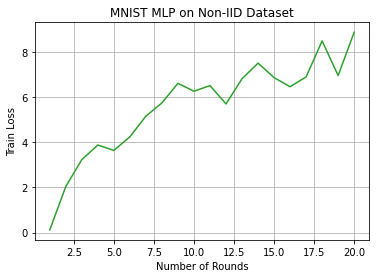

In [23]:
# number of training rounds
rounds = 20
# client fraction
C = 0.5
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.05
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "MNIST MLP on Non-IID Dataset", "green", 0.1)

##Test

In [24]:
criterion = nn.CrossEntropyLoss()
testing(mnist_mlp_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 43.604306

Test Accuracy of     0: 27% (21/76)
Test Accuracy of     1: 98% (89/90)
Test Accuracy of     2: 39% (36/91)
Test Accuracy of     3: 30% (22/73)
Test Accuracy of     4:  5% ( 5/89)
Test Accuracy of     5:  0% ( 0/68)
Test Accuracy of     6: 30% (19/62)
Test Accuracy of     7:  0% ( 0/81)
Test Accuracy of     8:  7% ( 6/77)
Test Accuracy of     9:  2% ( 2/83)

Final Test  Accuracy: 25.316 (200.0/790.0)


#MNIST CNN on IID

##Train

[63 68 37 23 92 64 33 76 62 84 44 31 77 35 97 17 52  2 86 66 14 57 56 10
 55 83 22 81 59  0 21 61  6 58 85 13 16  8 11 49 89 71 26 12 80 36 39 46
 65  5]
Round: 1... 	Average Loss: 0.498
[59  4 26 20 41 88 39  8 50 67 81 58 24  1 61 68 78 62 79 25 53 99 45  9
 55 35 30 87 47 90 97 29  6 71  3 82 72 94 44 42 85 64 23 36 18 37 65 32
 95 60]
Round: 2... 	Average Loss: 142.941
[ 3 12 26 65 40 33 70 83 86 51 81 15 47 34 31  0 89 54  8 59 69 62 50 49
 84 52 18 14 88 30 45 21 42 78 72 22 80 95 39  4 98 60 19 75 29 93  7 23
 68  6]
Round: 3... 	Average Loss: 2.299
[80 54 22 29 98 12 53 46  9 28 56 97 82 44 34 69 55 84 26 79 71 66 52  6
 43 85 40 16 25 63 48 37 31  2 17  4 94 92 39  5 95 15 47  8 78 51 59 90
 45 86]
Round: 4... 	Average Loss: 2.3
[47 40 36  9 79 98 75 95 12 88 65 20 42 91 28 62 31 92 14 27 51 69 67 38
 50 87 25 76 15 64 60 57  0 46 83 24 52 35 74 73  7 97  4 41 21 10 66 56
 63 19]
Round: 5... 	Average Loss: 174145683591.733
[91 37 12 44  5 82 95  1 73 52  9 22 66 40 42 71  8 20

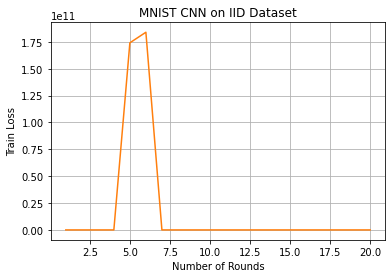

In [26]:
# number of training rounds
rounds = 20
# client fraction
C = 0.5
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.05
# data partition dictionary
iid_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, iid_dict, C, K, E, "MNIST CNN on IID Dataset", "orange", 0.1)

##Test

In [27]:
criterion = nn.CrossEntropyLoss()
testing(mnist_cnn_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 2.301318

Test Accuracy of     0:  0% ( 0/76)
Test Accuracy of     1: 100% (90/90)
Test Accuracy of     2:  0% ( 0/91)
Test Accuracy of     3:  0% ( 0/73)
Test Accuracy of     4:  0% ( 0/89)
Test Accuracy of     5:  0% ( 0/68)
Test Accuracy of     6:  0% ( 0/62)
Test Accuracy of     7:  0% ( 0/81)
Test Accuracy of     8:  0% ( 0/77)
Test Accuracy of     9:  0% ( 0/83)

Final Test  Accuracy: 11.392 (90.0/790.0)


#MNIST CNN on Non-IID

##Train

[20 65 12 76 81 40  5 19 95  9 55 22 64 51 45 57 10 33  2 50 54 75 28 42
  7  0  6 58 99 27 52  3 26 63 94 90 18 77 86 91 78 96 98 48 36 59  8 15
 24 93]
Round: 1... 	Average Loss: 0.118
[10 60 32 29 67 26 51  8 38 85 80 92 42 17 81  5 12 30 79  6 77 35 90 63
 88  1 49  7 40 73 68 78 82 54 25 39 36 94 64 72 11 96 45 86 13 62 33 15
 46 57]
Round: 2... 	Average Loss: 218851.007
[34 16 32 81 79 59 14 85  4 38 60 73 76 43 30 88 55 42 69 24 19 48 93 96
 31 39 94 86 77  5 15 13 47 68 51 58 23  3 57 40 50 44 97  1 53 28 22 91
 25 80]
Round: 3... 	Average Loss: 0.988
[99 55 68 86 29 94 90  6 44 47 93 21 25 31 97 43 80 12 61 72 24 77  3 91
 42 87 33  8  7 83 76 58 69 26 46 13 52 62 98 39 16 48 71 45 73  5 38 79
  0 18]
Round: 4... 	Average Loss: 0.973
[24 19  1 13 11 22 12 62 35 15 46 63 75 44 65 45  0 30 47 66  3 39 67 31
 23 51 26 49  4 20 18 64 25  6 40 17 93 29 60 48 21 92 53 91 94 57 42 98
 82 33]
Round: 5... 	Average Loss: 0.999
[85 68 75 51 71 98 17 83 84 92 54 39 19 34 18 60 61 25 48 73

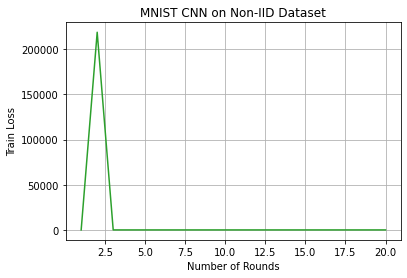

In [28]:
# number of training rounds
rounds = 20
# client fraction
C = 0.5
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 5
# batch size
batch_size = 10
# learning Rate
lr=0.05
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, C, K, E, "MNIST CNN on Non-IID Dataset", "green", 0.1)

##Test

In [29]:
criterion = nn.CrossEntropyLoss()
testing(mnist_cnn_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

Test Loss: 2.311738

Test Accuracy of     0:  0% ( 0/76)
Test Accuracy of     1:  0% ( 0/90)
Test Accuracy of     2:  0% ( 0/91)
Test Accuracy of     3:  0% ( 0/73)
Test Accuracy of     4: 100% (89/89)
Test Accuracy of     5:  0% ( 0/68)
Test Accuracy of     6:  0% ( 0/62)
Test Accuracy of     7:  0% ( 0/81)
Test Accuracy of     8:  0% ( 0/77)
Test Accuracy of     9:  0% ( 0/83)

Final Test  Accuracy: 11.266 (89.0/790.0)
